# Data cleaning de dataset finale de lettrage 

In [183]:
import pandas as pd 
import seaborn as sns

In [184]:
final_df = pd.read_csv("dataset_final.csv")

## Gerer les valeur manquantes et les colones inutles 

In [185]:
# Aperçu général
print("=== DIAGNOSTIC GÉNÉRAL ===")
print(f"Shape: {final_df.shape}")
print(f"Colonnes: {final_df.columns.tolist()}")
print(f"Types de données:")
print(final_df.dtypes)

# Valeurs manquantes
print("\n=== VALEURS MANQUANTES ===")
missing_values = final_df.isnull().sum()
missing_percent = (missing_values / len(final_df)) * 100
missing_df = pd.DataFrame({
    'Colonnes': missing_values.index,
    'Valeurs_manquantes': missing_values.values,
    'Pourcentage': missing_percent.values
})
print(missing_df[missing_df['Valeurs_manquantes'] > 0])

=== DIAGNOSTIC GÉNÉRAL ===
Shape: (27712, 23)
Colonnes: ['Unnamed: 0', 'id_releve', 'date_releve', 'libelle_operation', 'libelle_additionnel', 'debit', 'credit', 'date_valeur', 'etiquette', 'source_fusion', 'description', 'id_operation', 'date_operation', 'montant_operation', 'titre_operation', 'numero_reference', 'id_client', 'date_paiement', 'commentaires', 'statut', 'type_operation', 'categorie', 'montant_banque']
Types de données:
Unnamed: 0               int64
id_releve                int64
date_releve             object
libelle_operation       object
libelle_additionnel     object
debit                  float64
credit                 float64
date_valeur             object
etiquette                int64
source_fusion           object
description             object
id_operation             int64
date_operation          object
montant_operation      float64
titre_operation         object
numero_reference        object
id_client              float64
date_paiement           object
com

In [186]:
# Supprimer toutes les colonnes inutiles
final_df = final_df.drop(columns=['Unnamed: 0', 'debit', 'credit', 'id_client', 'date_paiement','source_fusion','id_releve','id_operation','statut'])

# Remplir les NaN restants
final_df['categorie'] = final_df['categorie'].fillna('AUCUNE')  # Pour les invoices
final_df['commentaires'] = final_df['commentaires'].fillna('')  # Vide pour texte

print("Colonnes finales:", final_df.columns.tolist())
print("Vérification - NaN restants:", final_df.isnull().sum().sum())
print("Shape final:", final_df.shape)

Colonnes finales: ['date_releve', 'libelle_operation', 'libelle_additionnel', 'date_valeur', 'etiquette', 'description', 'date_operation', 'montant_operation', 'titre_operation', 'numero_reference', 'commentaires', 'type_operation', 'categorie', 'montant_banque']
Vérification - NaN restants: 0
Shape final: (27712, 14)


## traitement des colones textuelle `libelle_operation` `libelle_additionnel` `description` `titre_operation` `commentaires`

In [187]:
# Séparer les deux types d'opérations
depenses_df = final_df[final_df['type_operation'] == 'depense'].copy()
factures_df = final_df[final_df['type_operation'] == 'facture'].copy()

print(f"DEPENSES: {len(depenses_df)} lignes")
print(f"FACTURES: {len(factures_df)} lignes")

# Colonnes texte à analyser
text_columns = ['libelle_operation', 'libelle_additionnel', 'description', 'titre_operation', 'commentaires']

print("\n" + "="*60)
print("ANALYSE DES DEPENSES")
print("="*60)

for col in text_columns:
    print(f"\n=== {col.upper()} - DEPENSES ===")
    print("Exemples:")
    print(depenses_df[col].dropna().head(5).tolist())
    print(f"Longueur moyenne: {depenses_df[col].str.len().mean():.1f}")
    print(f"Valeurs uniques: {depenses_df[col].nunique()}")

print("\n" + "="*60)
print("ANALYSE DES FACTURES")
print("="*60)

for col in text_columns:
    print(f"\n=== {col.upper()} - FACTURES ===")
    print("Exemples:")
    print(factures_df[col].dropna().head(5).tolist())
    print(f"Longueur moyenne: {factures_df[col].str.len().mean():.1f}")
    print(f"Valeurs uniques: {factures_df[col].nunique()}")

# Comparaison rapide
print("\n" + "="*60)
print("COMPARAISON RAPIDE")
print("="*60)
for col in text_columns:
    print(f"\n{col}:")
    print(f"  Depenses - Moy: {depenses_df[col].str.len().mean():.1f}, Uniques: {depenses_df[col].nunique()}")
    print(f"  Factures - Moy: {factures_df[col].str.len().mean():.1f}, Uniques: {factures_df[col].nunique()}")

DEPENSES: 14120 lignes
FACTURES: 13592 lignes

ANALYSE DES DEPENSES

=== LIBELLE_OPERATION - DEPENSES ===
Exemples:
['CARTE GROUPE Services Azure', 'CARTE GROUPE Services Azure', 'VIR GROUPE 5 ELEMENTS', 'VIR GROUPE 5 ELEMENTS', 'VIR GROUPE 5 ELEMENTS']
Longueur moyenne: 22.3
Valeurs uniques: 6284

=== LIBELLE_ADDITIONNEL - DEPENSES ===
Exemples:
['GROUPE REF: EXP202500010, EXP202500001', 'GROUPE REF: EXP202500010, EXP202500001', 'GROUPE REF: EXP202400002, EXP202500022, EXP202500156 +2 autres', 'GROUPE REF: EXP202400002, EXP202500022, EXP202500156 +2 autres', 'GROUPE REF: EXP202400002, EXP202500022, EXP202500156 +2 autres']
Longueur moyenne: 24.1
Valeurs uniques: 12434

=== DESCRIPTION - DEPENSES ===
Exemples:
['HÉBERGEMENT_CLOUD', 'SERVICES_UTILITAIRES', 'INVESTISSEMENT_INFRA', 'HÉBERGEMENT_CLOUD', 'LOGICIEL_RH']
Longueur moyenne: 14.9
Valeurs uniques: 31

=== TITRE_OPERATION - DEPENSES ===
Exemples:
['Services Azure', 'Téléphonie entreprise', 'Écran de travail', 'Cloudflare', 'Workda

In [188]:
import re

def preprocess_text(text) :
    # 1. Mettre en minuscules
    text = text.lower()
    # 2. Supprimer les caractères non imprimables
    text = re.sub(r"[^\x20-\x7E]", "", text)

    # 3. Normaliser les espaces
    text = re.sub(r"\s+", " ", text).strip()

    return text


In [189]:
text_columns = ['libelle_operation', 'libelle_additionnel', 'description', 'titre_operation', 'commentaires']
for col in text_columns:
    final_df[col] = final_df[col].apply(preprocess_text)

In [190]:
final_df[final_df["type_operation"] == "depense"]

,date_releve,libelle_operation,libelle_additionnel,date_valeur,etiquette,description,date_operation,montant_operation,titre_operation,numero_reference,commentaires,type_operation,categorie,montant_banque
13592,2025-07-07,carte groupe services azure,"groupe ref: exp202500010, exp202500001",2025-07-09,1,hbergement_cloud,2025-02-22,1136.81,services azure,EXP202500010,paiement group de 2 dpenses,depense,Services_Cloud,2182.74
13593,2025-07-07,carte groupe services azure,"groupe ref: exp202500010, exp202500001",2025-07-09,1,services_utilitaires,2025-07-03,1045.93,tlphonie entreprise,EXP202500001,paiement group de 2 dpenses,depense,Services_Publiques,2182.74
13594,2025-04-02,vir groupe 5 elements,"groupe ref: exp202400002, exp202500022, exp202...",2025-04-01,1,investissement_infra,2024-12-28,1370.98,cran de travail,EXP202400002,paiement group de 5 dpenses,depense,Équipement,9511.27
13595,2025-04-02,vir groupe 5 elements,"groupe ref: exp202400002, exp202500022, exp202...",2025-04-01,1,hbergement_cloud,2025-02-16,1701.25,cloudflare,EXP202500022,paiement group de 5 dpenses,depense,Services_Cloud,9511.27
13596,2025-04-02,vir groupe 5 elements,"groupe ref: exp202400002, exp202500022, exp202...",2025-04-01,1,logiciel_rh,2025-03-20,665.67,workday,EXP202500156,paiement group de 5 dpenses,depense,Outils_RH,9511.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27707,2024-12-04,carte partie frais tenue de compt 3,ref: exp202400073-p3 - partiel 3/5,2024-12-03,1,frais_banque,2024-11-20,716.66,frais tenue de compte,EXP202400073,paiement partiel 3 de 5,depense,Frais_Bancaires,136.29
27708,2024-12-10,virement partiel exp202400073 4/5,ref: exp202400073-p4 - partiel 4/5,2024-12-10,1,frais_banque,2024-11-20,716.66,frais tenue de compte,EXP202400073,paiement partiel 4 de 5,depense,Frais_Bancaires,98.55
27709,2024-12-09,paiement cb frais_bancaires partie 5,ref: exp202400073-p5 - partiel 5/5,2024-12-10,1,frais_banque,2024-11-20,716.66,frais tenue de compte,EXP202400073,paiement partiel 5 de 5,depense,Frais_Bancaires,113.40
27710,2024-08-30,chque n400020 partie 1,ref: exp202400020-p1 - partiel 1/2,2024-08-30,1,avis_pro,2024-08-20,9463.26,audit technique,EXP202400020,paiement partiel 1 de 2,depense,Conseil,4697.00


In [191]:
abreviation_banquaire = {
    # Opérations courantes
    'vir': 'Virement',
    'prlv': 'Prélèvement', 
    'cb': 'Carte Bancaire',
    'dab': 'Distributeur Automatique de Billets',
    'gab': 'Guichet Automatique Bancaire',
    'tpe': 'Terminal de Paiement Électronique',
    'tip': 'Titre Interbancaire de Paiement',
    'lcr': 'Lettre de Change Relevé',
    'rib': 'Relevé d\'Identité Bancaire',
    
    # Codes internationaux
    'iban': 'International Bank Account Number',
    'bic': 'Bank Identifier Code',
    'swift': 'Society for Worldwide Interbank Financial Telecommunication',
    'sepa': 'Single Euro Payments Area',
    'ach': 'Automated Clearing House',
    'bban': 'Basic Bank Account Number',
    'mt103': 'Message Type 103',
    
    # Types de comptes
    'cc': 'Compte Courant',
    'cel': 'Compte Épargne Logement',
    'pel': 'Plan Épargne Logement',
    'lep': 'Livret d\'Épargne Populaire',
    'ldd': 'Livret de Développement Durable',
    'la': 'Livret A',
    'pea': 'Plan d\'Épargne en Actions',
    'av': 'Assurance Vie',
    
    # Frais et commissions
    'agios': 'Intérêts débiteurs',
    'com': 'Commission',
    'cotis': 'Cotisation',
    'abonnt': 'Abonnement',
    'frais': 'Frais bancaires',
    
    # Crédits et emprunts
    'cat': 'Crédit Amortissable Traditionnel',
    'pas': 'Prêt à l\'Accession Sociale',
    'ptz': 'Prêt à Taux Zéro',
    'taeg': 'Taux Annuel Effectif Global',
    'teg': 'Taux Effectif Global',
    
    # Moyens de paiement
    'cheq': 'Chèque',
    'especes': 'Espèces',
    'avis_ech': 'Avis d\'Échéance',
    
    # Organismes
    'bceao': 'Banque Centrale des États de l\'Afrique de l\'Ouest',
    'bam': 'Bank Al-Maghrib',
    'bce': 'Banque Centrale Européenne',
    'fmi': 'Fonds Monétaire International',
    'bri': 'Banque des Règlements Internationaux',
    'acpr': 'Autorité de Contrôle Prudentiel et de Résolution',
    
    # Termes comptables
    'debit': 'débit',
    'credit': 'crédit',
    'decouvert': 'découvert', 
    'provision': 'provision',
    'rapproch': 'rapprochement bancaire',
    'ref' : 'reference'
}

In [192]:
def correction_dabreviation(text):
    split = text.split()
    return " ".join([mot if not mot in abreviation_banquaire.keys() else abreviation_banquaire[mot].lower() for mot in split])
for col in text_columns:
    final_df[col] = final_df[col].apply(correction_dabreviation)

In [193]:
final_df[final_df["type_operation"] == "depense"]

,date_releve,libelle_operation,libelle_additionnel,date_valeur,etiquette,description,date_operation,montant_operation,titre_operation,numero_reference,commentaires,type_operation,categorie,montant_banque
13592,2025-07-07,carte groupe services azure,"groupe ref: exp202500010, exp202500001",2025-07-09,1,hbergement_cloud,2025-02-22,1136.81,services azure,EXP202500010,paiement group de 2 dpenses,depense,Services_Cloud,2182.74
13593,2025-07-07,carte groupe services azure,"groupe ref: exp202500010, exp202500001",2025-07-09,1,services_utilitaires,2025-07-03,1045.93,tlphonie entreprise,EXP202500001,paiement group de 2 dpenses,depense,Services_Publiques,2182.74
13594,2025-04-02,virement groupe 5 elements,"groupe ref: exp202400002, exp202500022, exp202...",2025-04-01,1,investissement_infra,2024-12-28,1370.98,cran de travail,EXP202400002,paiement group de 5 dpenses,depense,Équipement,9511.27
13595,2025-04-02,virement groupe 5 elements,"groupe ref: exp202400002, exp202500022, exp202...",2025-04-01,1,hbergement_cloud,2025-02-16,1701.25,cloudflare,EXP202500022,paiement group de 5 dpenses,depense,Services_Cloud,9511.27
13596,2025-04-02,virement groupe 5 elements,"groupe ref: exp202400002, exp202500022, exp202...",2025-04-01,1,logiciel_rh,2025-03-20,665.67,workday,EXP202500156,paiement group de 5 dpenses,depense,Outils_RH,9511.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27707,2024-12-04,carte partie frais bancaires tenue de compt 3,ref: exp202400073-p3 - partiel 3/5,2024-12-03,1,frais_banque,2024-11-20,716.66,frais bancaires tenue de compte,EXP202400073,paiement partiel 3 de 5,depense,Frais_Bancaires,136.29
27708,2024-12-10,virement partiel exp202400073 4/5,ref: exp202400073-p4 - partiel 4/5,2024-12-10,1,frais_banque,2024-11-20,716.66,frais bancaires tenue de compte,EXP202400073,paiement partiel 4 de 5,depense,Frais_Bancaires,98.55
27709,2024-12-09,paiement carte bancaire frais_bancaires partie 5,ref: exp202400073-p5 - partiel 5/5,2024-12-10,1,frais_banque,2024-11-20,716.66,frais bancaires tenue de compte,EXP202400073,paiement partiel 5 de 5,depense,Frais_Bancaires,113.40
27710,2024-08-30,chque n400020 partie 1,ref: exp202400020-p1 - partiel 1/2,2024-08-30,1,avis_pro,2024-08-20,9463.26,audit technique,EXP202400020,paiement partiel 1 de 2,depense,Conseil,4697.00


## les colones categoriele 

In [194]:
final_df["categorie"] = final_df["categorie"].apply(preprocess_text)

In [195]:
final_df["categorie"].value_counts()

categorie
aucune                  13592
licences_logicielles     1442
juridique_conformit      1377
frais_bancaires          1328
outils_rh                1293
services_publiques       1271
quipement                1228
abonnements              1223
services_cloud           1203
assurances                867
formations                548
marketing                 543
divertissement            386
fournitures_bureau        364
maintenance               353
conseil                   350
dplacements               344
Name: count, dtype: int64

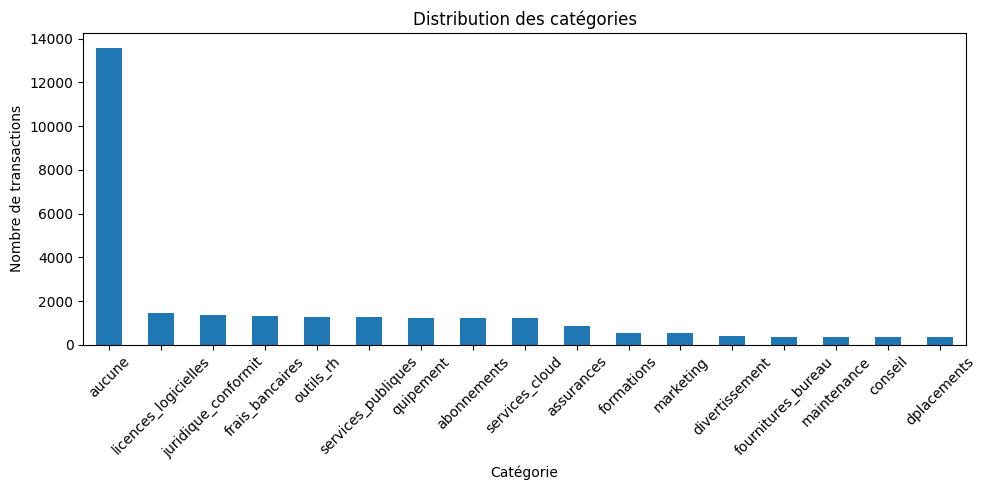

In [196]:
import matplotlib.pyplot as plt
import seaborn as sns

# Afficher les fréquences des catégories
final_df['categorie'].value_counts().plot(kind='bar', figsize=(10, 5))
plt.title("Distribution des catégories")
plt.xlabel("Catégorie")
plt.ylabel("Nombre de transactions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## traitemant des colones numerique `montant_banque`  `montant_operation`

In [197]:
numerique_columns = ["montant_banque","montant_operation"]

5.478331970564186 montant_banque
2.6528258362168398 montant_banque
1.4567392583872867 montant_banque
4.857142857142857 montant_banque
3.1088082901554404 montant_banque
3.77906976744186 montant_banque
4.562043795620438 montant_banque
4.1208791208791204 montant_banque
4.292168674698795 montant_banque
3.195352214960058 montant_banque
3.0513176144244105 montant_banque
3.6827195467422094 montant_banque
3.314917127071823 montant_banque
4.408352668213457 montant_banque
4.153094462540716 montant_banque
4.239401496259352 montant_banque
4.012588512981904 montant_banque


C:\Users\dell\AppData\Local\Temp\ipykernel_30256\1458516465.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=outliers_df, x="categorie", y="pourcentage_outliers", palette="coolwarm")


0.0 montant_operation
0.0 montant_operation
2.0306062389640966 montant_operation
0.0 montant_operation
0.0 montant_operation
0.0 montant_operation
0.0 montant_operation
0.0 montant_operation
0.0 montant_operation
0.0 montant_operation
0.0 montant_operation
0.0 montant_operation
0.0 montant_operation
0.0 montant_operation
0.0 montant_operation
0.0 montant_operation
0.0 montant_operation


C:\Users\dell\AppData\Local\Temp\ipykernel_30256\1458516465.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=outliers_df, x="categorie", y="pourcentage_outliers", palette="coolwarm")


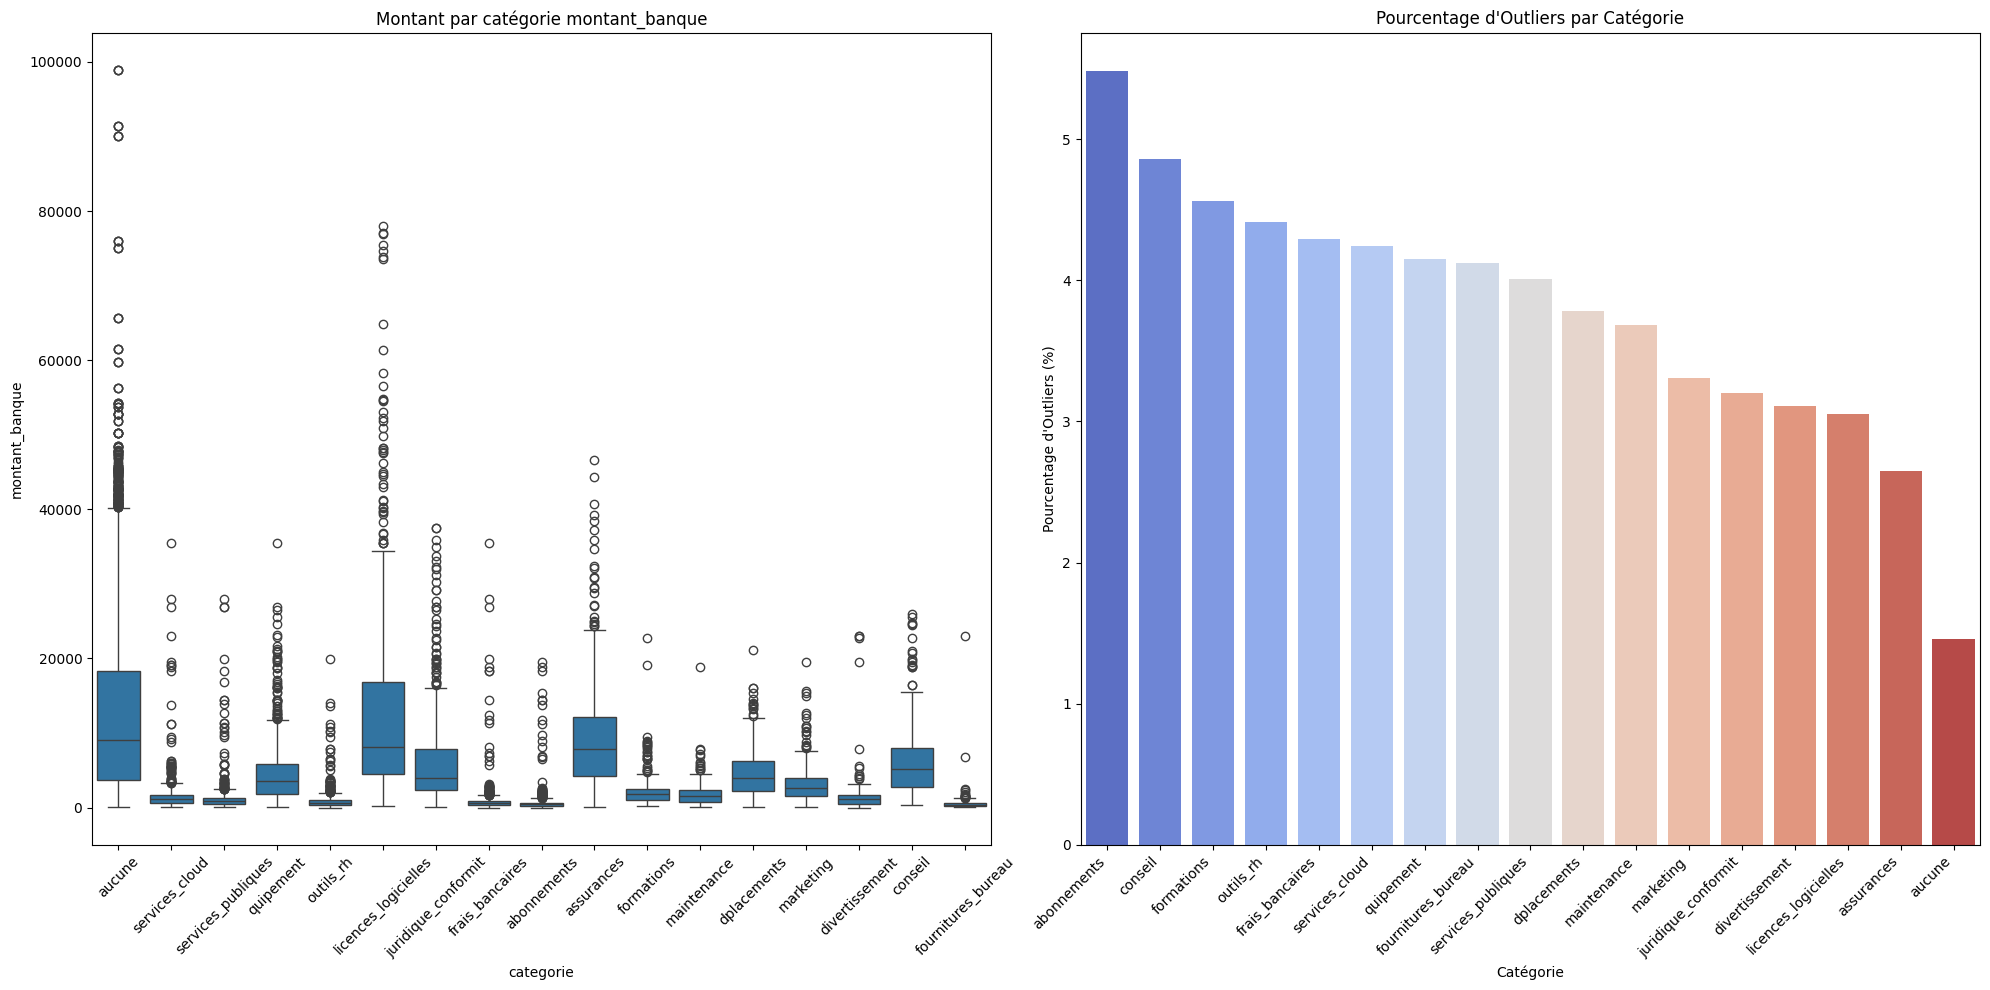

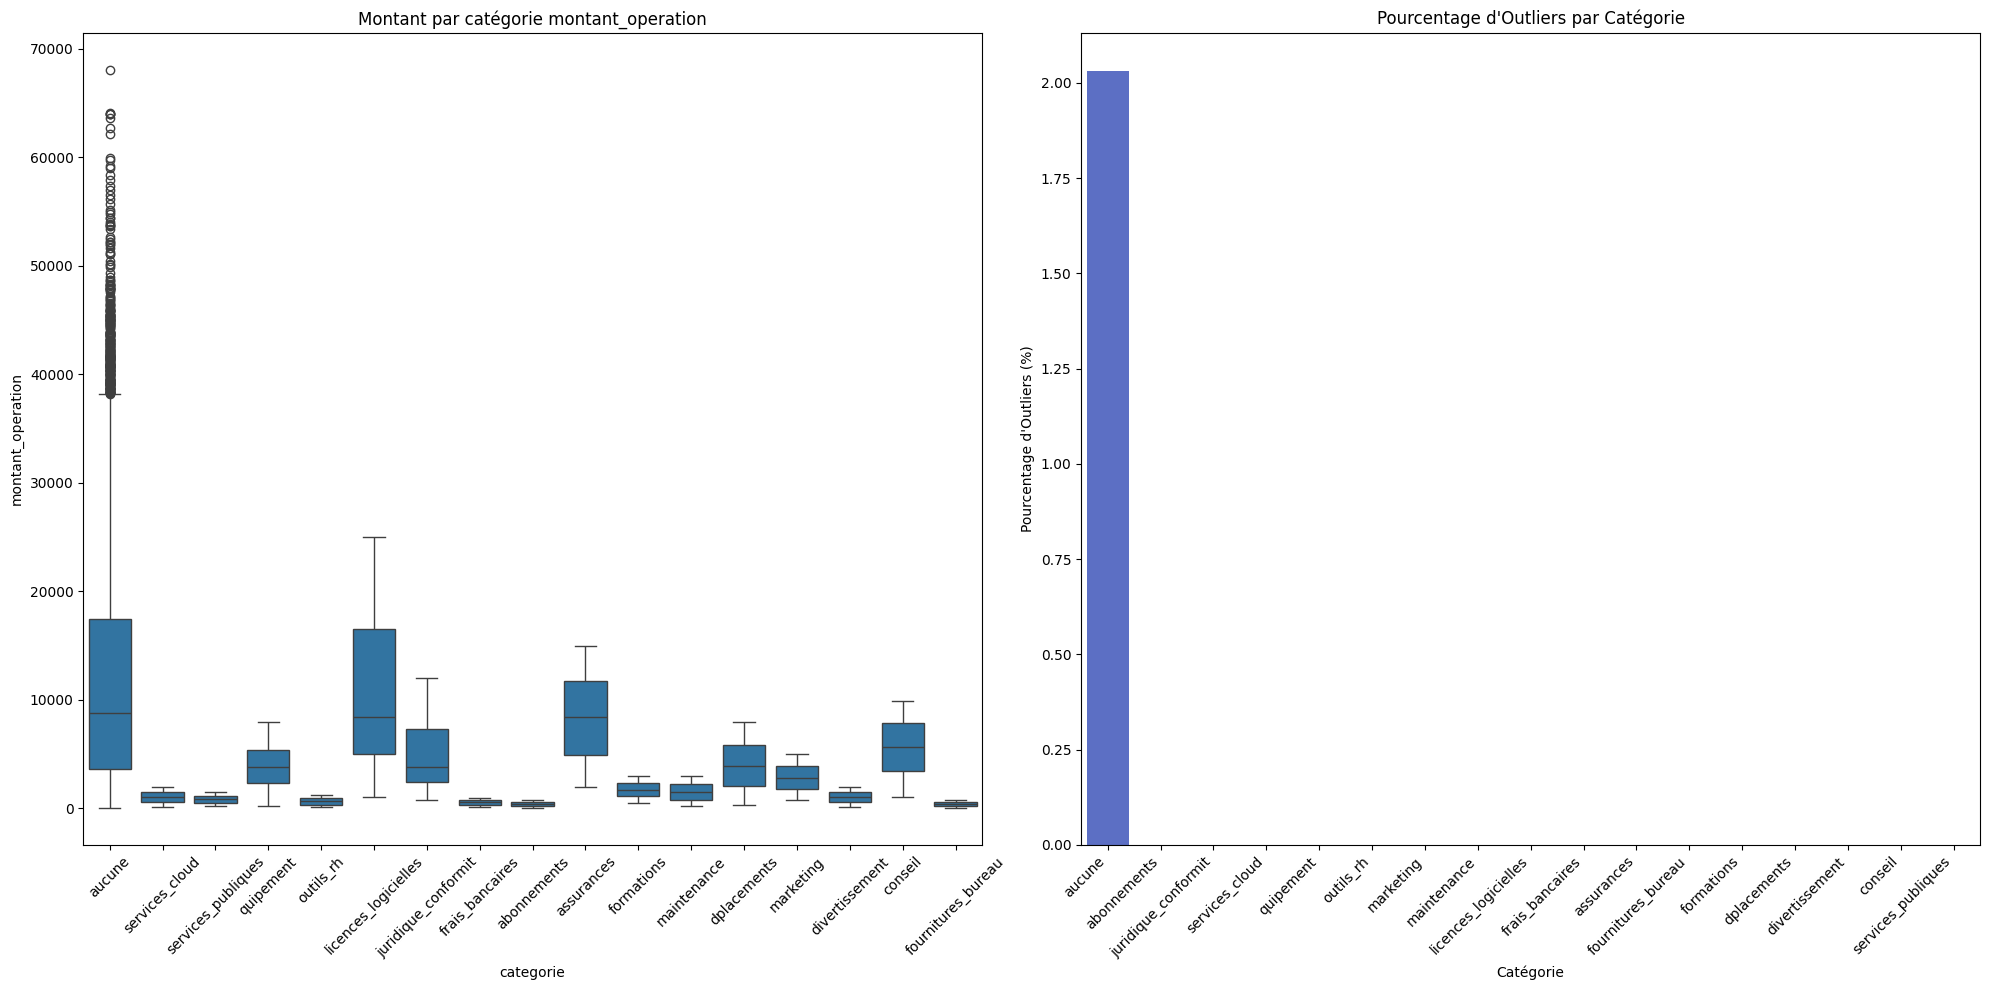

In [198]:
def detect_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return (series < lower) | (series > upper)

# Calcul du pourcentage d'outliers par catégorie
def get_outlier_percente(final_df,colone):
    outlier_stats = []

    for cat, group in final_df.groupby("categorie"):
        outliers = detect_outliers_iqr(group[colone])
        total = len(group)
        nb_outliers = outliers.sum()
        pct = (nb_outliers / total) * 100
        print(pct,col)
        outlier_stats.append({
            "categorie": cat,
            "pourcentage_outliers": round(pct, 2)
        })

    # Créer le DataFrame
    outliers_df = pd.DataFrame(outlier_stats)
    return outliers_df

# Trier pour plus de lisibilité
for col in numerique_columns:
    outliers_df = get_outlier_percente(final_df,col).sort_values(by="pourcentage_outliers", ascending=False)

    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    sns.boxplot(data=final_df, x='categorie', y=col)
    plt.title(f"Montant par catégorie {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.subplot(1,2,2)
    sns.barplot(data=outliers_df, x="categorie", y="pourcentage_outliers", palette="coolwarm")
    plt.title("Pourcentage d'Outliers par Catégorie")
    plt.ylabel("Pourcentage d'Outliers (%)")
    plt.xlabel("Catégorie")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
plt.show()



In [199]:
def remove_outliers_iqr(df, column, group_by):
    df_cleaned = pd.DataFrame()

    # Pour chaque catégorie
    for cat, group in df.groupby(group_by):
        q1 = group[column].quantile(0.25)
        q3 = group[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # On garde les valeurs dans l'intervalle
        group_cleaned = group[(group[column] >= lower_bound) & (group[column] <= upper_bound)]
        df_cleaned = pd.concat([df_cleaned, group_cleaned])

    return df_cleaned
for col in numerique_columns :
    
 final_df = remove_outliers_iqr(final_df,col,'categorie')

0.7785467128027681 montant_banque
0.23696682464454977 montant_banque
0.2885783718104496 montant_banque
1.2012012012012012 montant_banque
0.0 montant_banque
0.6042296072507553 montant_banque
0.19120458891013384 montant_banque
0.5730659025787965 montant_banque
0.3933910306845004 montant_banque
0.3750937734433608 montant_banque
0.28612303290414876 montant_banque
0.0 montant_banque
0.7619047619047619 montant_banque
0.24271844660194172 montant_banque
0.33984706881903143 montant_banque
0.4340277777777778 montant_banque
0.24590163934426232 montant_banque


C:\Users\dell\AppData\Local\Temp\ipykernel_30256\520602939.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=outliers_df, x="categorie", y="pourcentage_outliers", palette="coolwarm")


0.0 montant_operation
0.0 montant_operation
0.6227217496962333 montant_operation
0.0 montant_operation
0.0 montant_operation
0.0 montant_operation
0.0 montant_operation
0.0 montant_operation
0.0 montant_operation
0.0 montant_operation
0.0 montant_operation
0.0 montant_operation
0.0 montant_operation
0.0 montant_operation
0.0 montant_operation
0.0 montant_operation
0.0 montant_operation


C:\Users\dell\AppData\Local\Temp\ipykernel_30256\520602939.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=outliers_df, x="categorie", y="pourcentage_outliers", palette="coolwarm")


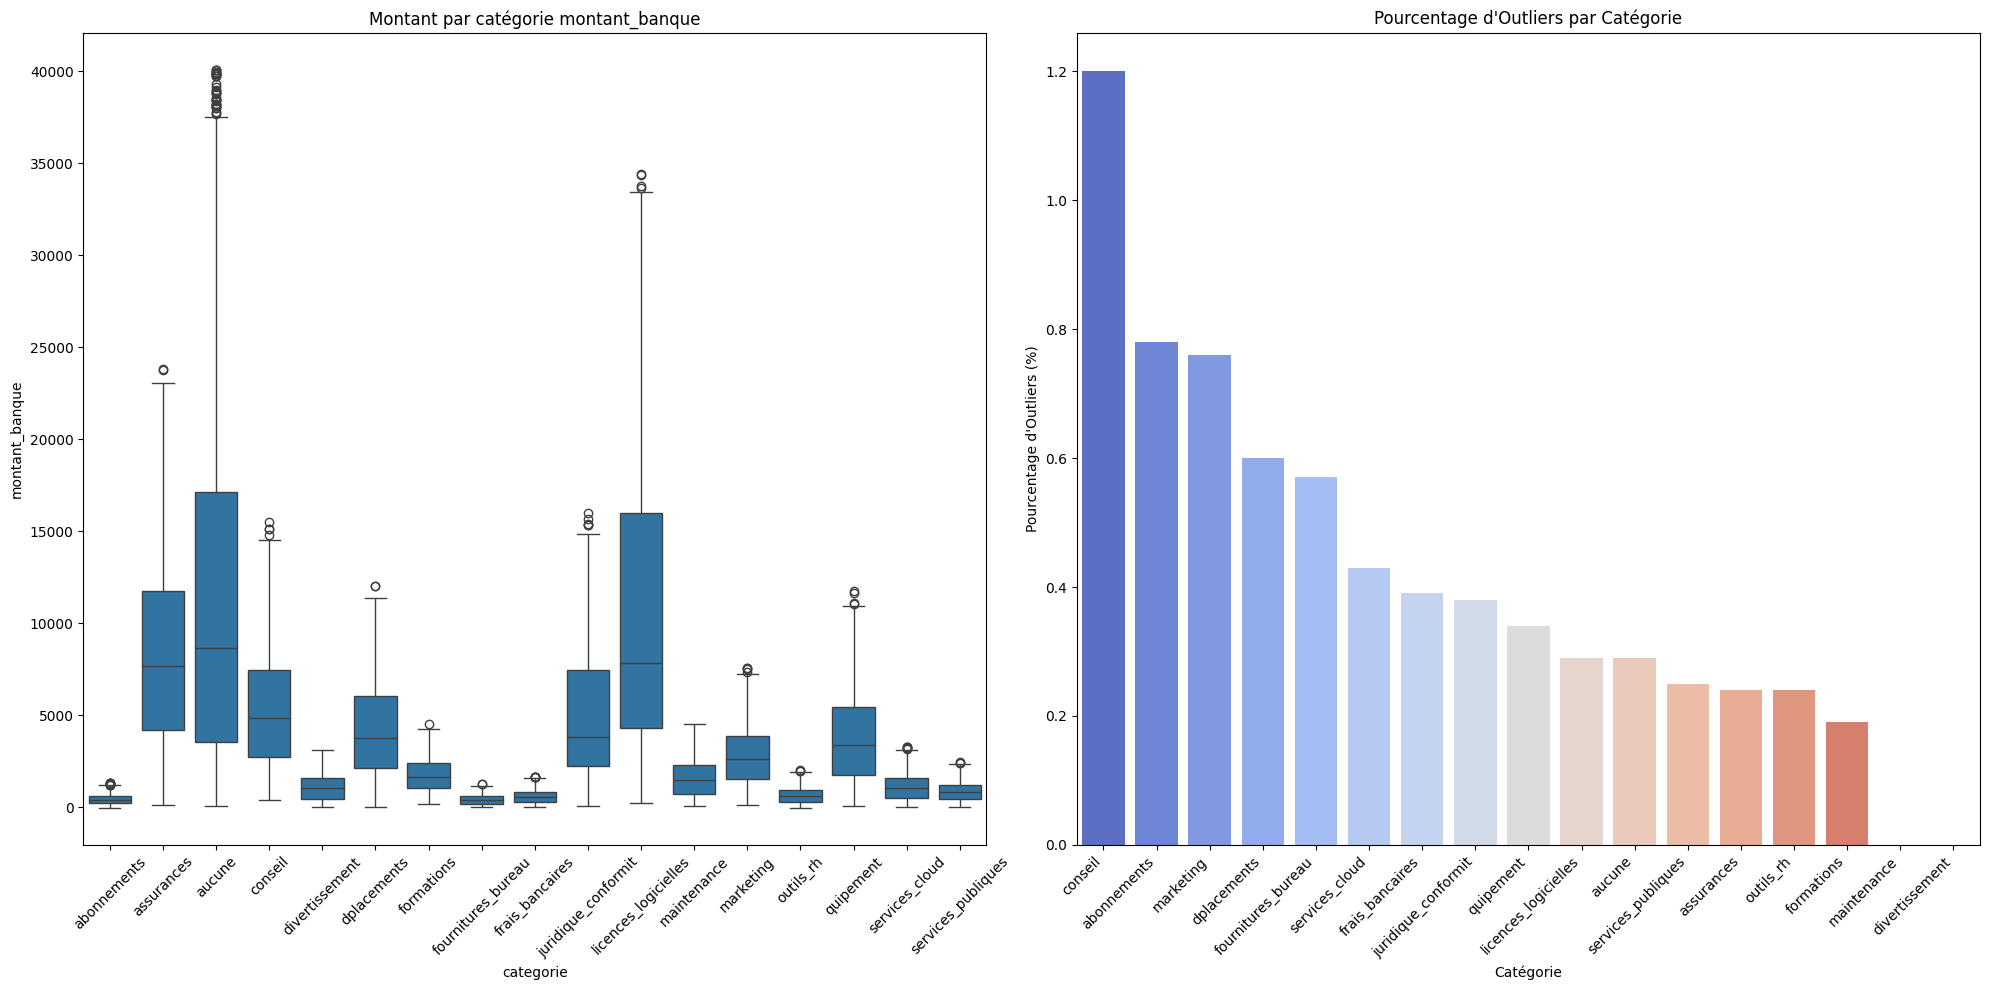

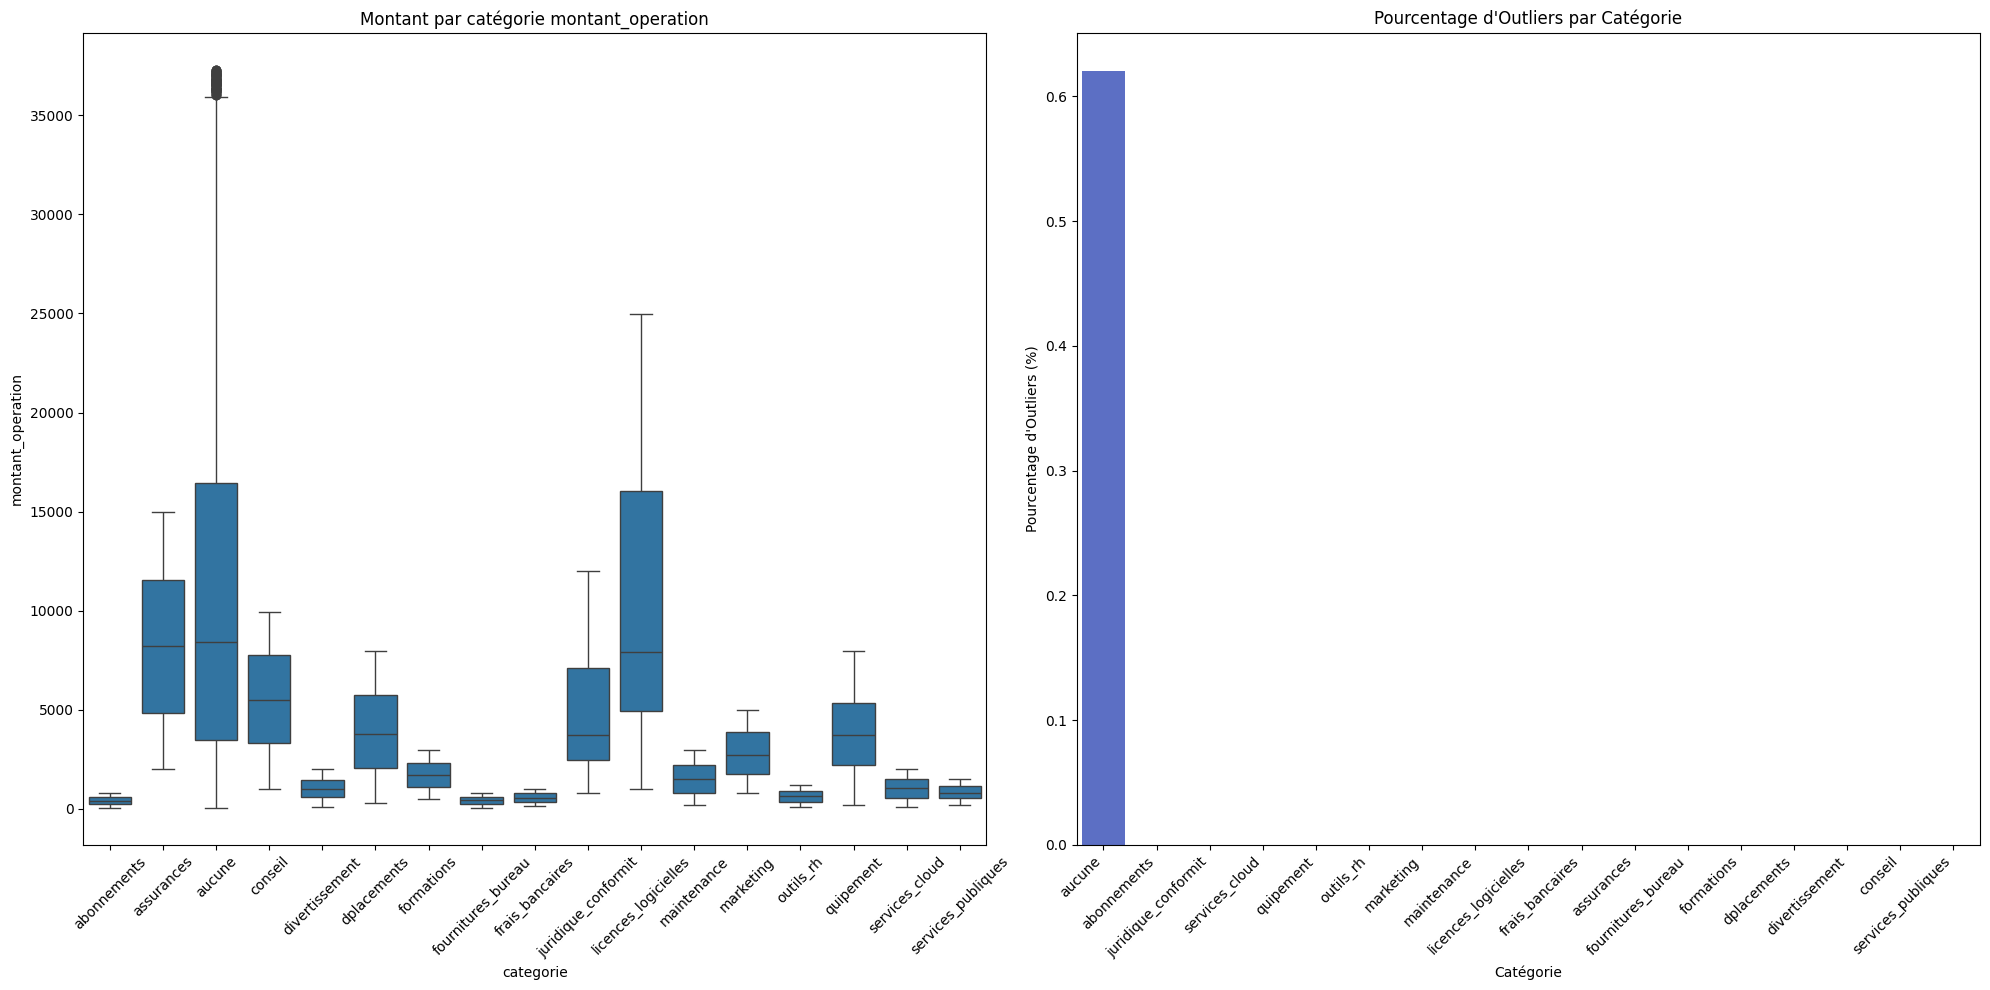

In [200]:
for col in numerique_columns:
    outliers_df = get_outlier_percente(final_df,col).sort_values(by="pourcentage_outliers", ascending=False)

    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    sns.boxplot(data=final_df, x='categorie', y=col)
    plt.title(f"Montant par catégorie {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.subplot(1,2,2)
    sns.barplot(data=outliers_df, x="categorie", y="pourcentage_outliers", palette="coolwarm")
    plt.title("Pourcentage d'Outliers par Catégorie")
    plt.ylabel("Pourcentage d'Outliers (%)")
    plt.xlabel("Catégorie")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
plt.show()



In [201]:
correlation = final_df[numerique_columns[0]].corr(final_df[numerique_columns[1]])
print(f"Corrélation entre colonne1 et colonne2 : {correlation}")


Corrélation entre colonne1 et colonne2 : 0.9316452780887299


## traitement des donnes temporelle 

In [202]:
date_columns = ['date_releve','date_operation']

In [203]:
for col in date_columns:
    print(final_df[col].dtypes) 

object
object


In [204]:
for col in date_columns:
 final_df[col] = pd.to_datetime(final_df[col], errors='coerce')
for col in date_columns:
    print(final_df[col].dtypes) 

datetime64[ns]
datetime64[ns]


In [205]:
print(final_df.shape)
final_df

(26730, 14)


,date_releve,libelle_operation,libelle_additionnel,date_valeur,etiquette,description,date_operation,montant_operation,titre_operation,numero_reference,commentaires,type_operation,categorie,montant_banque
13610,2024-08-31,prelevement auto services_cloud groupe,"groupe ref: exp202400172, exp202400152",2024-09-02,1,outils_numriques,2024-08-26,448.85,zoom pro,EXP202400152,paiement group de 2 dpenses,depense,abonnements,988.89
13674,2025-05-31,paiement carte bancaire abonnements lot,"groupe ref: exp202500092, exp202500066",2025-05-30,1,plateforme_saas,2025-03-27,186.47,github entreprise,EXP202500092,paiement group de 2 dpenses,depense,abonnements,685.81
13858,2024-12-14,paiement carte bancaire abonnements,ref: exp202403766 - mensuel,2024-12-14,1,outils_numriques,2024-12-13,518.18,github entreprise,EXP202403766,paiement depense exp202403766,depense,abonnements,518.18
13863,2025-03-01,prlvement auto abonnements,ref: exp202503364 - mensuel,2025-03-01,1,outils_numriques,2025-03-01,534.96,slack premium,EXP202503364,paiement depense exp202503364,depense,abonnements,534.96
13869,2025-03-03,virement exp202501830,ref: exp202501830 - mensuel,2025-03-03,1,outils_numriques,2025-03-01,524.38,adobe creative cloud,EXP202501830,paiement depense exp202501830,depense,abonnements,524.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27559,2024-12-26,prlvement automatique services_publiques partie 1,ref: exp202400027-p1 - partiel 1/5,2024-12-28,1,services_utilitaires,2024-12-26,218.07,facture lectricit,EXP202400027,paiement partiel 1 de 5,depense,services_publiques,124.66
27560,2025-01-05,prlvement automatique services_publiques partie 2,ref: exp202400027-p2 - partiel 2/5,2025-01-04,1,services_utilitaires,2024-12-26,218.07,facture lectricit,EXP202400027,paiement partiel 2 de 5,depense,services_publiques,53.04
27561,2025-01-05,paiement carte bancaire services_publiques par...,ref: exp202400027-p3 - partiel 3/5,2025-01-06,1,services_utilitaires,2024-12-26,218.07,facture lectricit,EXP202400027,paiement partiel 3 de 5,depense,services_publiques,8.29
27562,2025-01-12,transfert services_publiques partie 4,ref: exp202400027-p4 - partiel 4/5,2025-01-12,1,services_utilitaires,2024-12-26,218.07,facture lectricit,EXP202400027,paiement partiel 4 de 5,depense,services_publiques,13.47
